In [19]:
import sys
from pathlib import Path

project_root = Path('..').resolve()
sys.path.insert(0, str(project_root / 'src'))

In [20]:
from riskmc.data import load_prices
from riskmc.returns import log_returns
from riskmc.simulation import mc_gaussian_returns
from riskmc.risk_metrics import var, cvar
from riskmc.plots import plot_pnl_distribution


In [21]:
assets = ['SPY', 'TLT', 'GLD', 'QQQ']
weights = [0.4, 0.3, 0.2, 0.1]
#weights chosen like this as
#equities (eg SPY) dominate risk
#bonds (eg TLT) as ballast
#gold (GLD) as hedge
#QQQ as growth tilt

N_SIMS = 100_000
HORIZON = 1

In [22]:
import numpy as np

In [23]:
data_path = project_root / 'data' / 'prices.csv'
prices = load_prices(data_path)
rets = log_returns(prices)

In [24]:
#use this if dataset is made larger, could be more accurate
#for now, dataset too small so use [0.4, 0.3, 0.2, 0.1]
'''
vols = rets.std()
inv_vol = 1/vols
weights = inv_vol / inv_vol
weights
'''

'\nvols = rets.std()\ninv_vol = 1/vols\nweights = inv_vol / inv_vol\nweights\n'

In [25]:
print(prices)
print(rets)

               SPY    TLT     GLD     QQQ
Date                                     
2026-01-14  690.36  88.33  422.13  630.00
2026-01-13  691.66  88.32  421.84  632.10
2026-01-12  692.24  88.30  423.50  631.55
2026-01-09  687.72  88.10  420.90  625.40
2026-01-08  685.81  87.90  419.75  622.80
2026-01-07  688.50  88.05  421.30  626.20
2026-01-06  689.72  87.80  420.18  624.95
2025-12-31  681.92  88.99  399.02  615.22
                 SPY       TLT       GLD       QQQ
Date                                              
2026-01-13  0.001881 -0.000113 -0.000687  0.003328
2026-01-12  0.000838 -0.000226  0.003927 -0.000870
2026-01-09 -0.006551 -0.002268 -0.006158 -0.009786
2026-01-08 -0.002781 -0.002273 -0.002736 -0.004166
2026-01-07  0.003915  0.001705  0.003686  0.005444
2026-01-06  0.001770 -0.002843 -0.002662 -0.001998
2025-12-31 -0.011373  0.013463 -0.051672 -0.015692


In [26]:
portfolio_returns = rets @ weights
print(portfolio_returns)

Date
2026-01-13    0.000914
2026-01-12    0.000966
2026-01-09   -0.005511
2026-01-08   -0.002758
2026-01-07    0.003359
2026-01-06   -0.000877
2025-12-31   -0.012414
dtype: float64


In [27]:
#monte carlo sim
sim_asset_returns = mc_gaussian_returns(rets, N_SIMS, HORIZON)
sim_port_returns = sim_asset_returns @ weights

In [ ]:
#risk metrics
var_95 = var(sim_port_returns, 0.95)
var_99 = var(sim_port_returns, 0.99)
cvar_99 = cvar(sim_port_returns, 0.99)

var_95, var_99, cvar_99

(np.float64(0.011103200027425637),
 np.float64(0.014676401637045013),
 np.float64(0.016499798235142416))

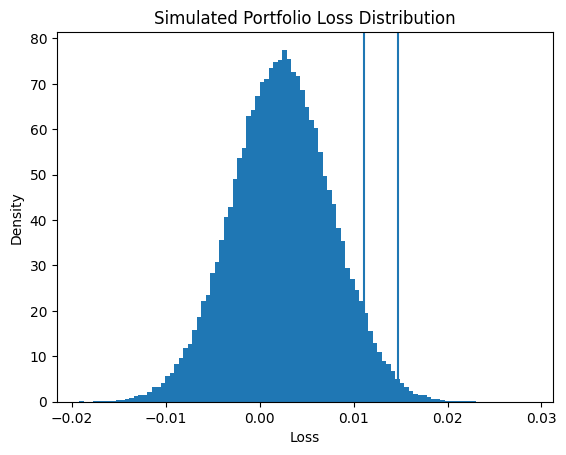

In [29]:
plot_pnl_distribution(sim_port_returns, var_95, var_99)